In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"
from IPython.display import display

In [2]:
import warnings
import os
warnings.filterwarnings("ignore")

DATASET_FOLDER = "../dataset"

In [3]:
airports_path = f"{DATASET_FOLDER}/airports.csv" 
flights_path = f"{DATASET_FOLDER}/flights.csv"      

df_airports = pd.read_csv(airports_path)
df_flights = pd.read_csv(flights_path)

print(f"Airports data shape: {df_airports.shape}")
print(f"Flights data shape: {df_flights.shape}")

Airports data shape: (7184, 14)
Flights data shape: (523275, 28)


In [4]:
display(df_flights.head())
print(df_flights.columns)
display(df_flights.describe())

,actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,...,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions
0,NaN,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:02:07,P,NaN,NaN,NaN
1,NaN,PHPXY,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:00,NaN,NaN,NaN,NaN
2,NaN,NaN,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:29,P,NaN,NaN,NaN
3,2018-01-01T03:22:00.000+01:00,PHPXB,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['DEP'],['AMS'],2018-01-01,03:30:00,NaN,NaN,NaN,NaN
4,2018-01-01T05:58:22.000+01:00,PHHSJ,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,...,TRA,NaN,['DEP'],['SPC'],2018-01-01,06:00:00,J,1.0,NaN,NaN


Index(['actualOffBlockTime', 'aircraftRegistration', 'aircraftType.iatamain',
       'aircraftType.iatasub', 'airlineCode', 'baggageClaim',
       'estimatedLandingTime', 'expectedTimeBoarding',
       'expectedTimeGateClosing', 'expectedTimeGateOpen', 'expectedTimeOnBelt',
       'flightDirection', 'flightName', 'flightNumber', 'gate', 'id',
       'mainFlight', 'prefixIATA', 'prefixICAO', 'publicEstimatedOffBlockTime',
       'publicFlightState.flightStates', 'route.destinations', 'scheduleDate',
       'scheduleTime', 'serviceType', 'terminal', 'transferPositions',
       'transferPositions.transferPositions'],
      dtype='object')


,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeOnBelt,flightNumber,id,terminal,transferPositions
count,521867.000000,0.0,0.0,0.0,521572.000000,5.232750e+05,494629.000000,0.0
mean,805.384765,NaN,NaN,NaN,5431.027120,1.241429e+17,1.581781,NaN
std,1319.735519,NaN,NaN,NaN,3416.845675,4.055064e+14,0.668756,NaN
min,6.000000,NaN,NaN,NaN,0.000000,1.234004e+17,1.000000,NaN
25%,64.000000,NaN,NaN,NaN,1731.000000,1.238009e+17,1.000000,NaN
50%,100.000000,NaN,NaN,NaN,6147.000000,1.241591e+17,1.000000,NaN
75%,1294.000000,NaN,NaN,NaN,8638.000000,1.244893e+17,2.000000,NaN
max,5108.000000,NaN,NaN,NaN,9999.000000,1.248968e+17,3.000000,NaN


In [5]:
display(df_airports.head())
print(df_airports.columns)
display(df_airports.describe())

,Airport,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


Index(['Airport', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'],
      dtype='object')


,Airport,Latitude,Longitude,Altitude
count,7184.000000,7184.000000,7184.000000,7184.000000
mean,4672.248886,25.950874,-2.946702,1011.833101
std,3324.796152,28.239954,85.993653,1608.349308
min,1.000000,-90.000000,-179.876999,-1266.000000
25%,1853.750000,7.366353,-79.467924,66.000000
50%,3809.500000,34.262400,5.820455,354.000000
75%,7187.250000,47.290104,50.838224,1197.250000
max,12057.000000,82.517799,179.951004,14219.000000


In [6]:
print("Flights info:")
df_flights.info()
print("\Airports info:")
df_airports.info()

Flights info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523275 entries, 0 to 523274
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   actualOffBlockTime                   487716 non-null  object 
 1   aircraftRegistration                 495732 non-null  object 
 2   aircraftType.iatamain                521108 non-null  object 
 3   aircraftType.iatasub                 518308 non-null  object 
 4   airlineCode                          521867 non-null  float64
 5   baggageClaim                         0 non-null       float64
 6   estimatedLandingTime                 0 non-null       float64
 7   expectedTimeBoarding                 426919 non-null  object 
 8   expectedTimeGateClosing              426919 non-null  object 
 9   expectedTimeGateOpen                 414178 non-null  object 
 10  expectedTimeOnBelt                   0 non-null       float64
 11 

In [8]:
# Combine scheduleDate and scheduleTime into one datetime column for scheduled departure
df_flights['scheduledDeparture'] = pd.to_datetime(df_flights['scheduleDate'] + ' ' + df_flights['scheduleTime'])
df_flights['scheduledDeparture'] = df_flights['scheduledDeparture'].dt.tz_localize('UTC+01:00')

# Convert actualOffBlockTime to datetime (errors='coerce' handles any bad formats)
df_flights['actualOffBlockTime'] = pd.to_datetime(df_flights['actualOffBlockTime'], errors='coerce')

print(df_flights['scheduledDeparture'].dtype)
print(df_flights['actualOffBlockTime'].dtype)


# Compute delay in minutes (difference between actual and scheduled departure)
df_flights['delay_minutes'] = (df_flights['actualOffBlockTime'] - df_flights['scheduledDeparture']).dt.total_seconds() / 60

# Drop rows with missing delay values
df_flights.dropna(subset=['delay_minutes'], inplace=True)

# Optionally, you might want to treat early departures as 0 delay
df_flights['delay_minutes'] = df_flights['delay_minutes'].apply(lambda x: x if x > 0 else 0)

# Check basic summary statistics
print(df_flights['delay_minutes'].describe())

datetime64[ns, UTC+01:00]
datetime64[ns, UTC+01:00]
count    194005.000000
mean         14.662993
std          48.029228
min           0.000000
25%           1.216667
50%           6.000000
75%          14.983333
max        4685.350000
Name: delay_minutes, dtype: float64


In [9]:
df_flights["delay_minutes_log"] = np.log1p(df_flights["delay_minutes"])

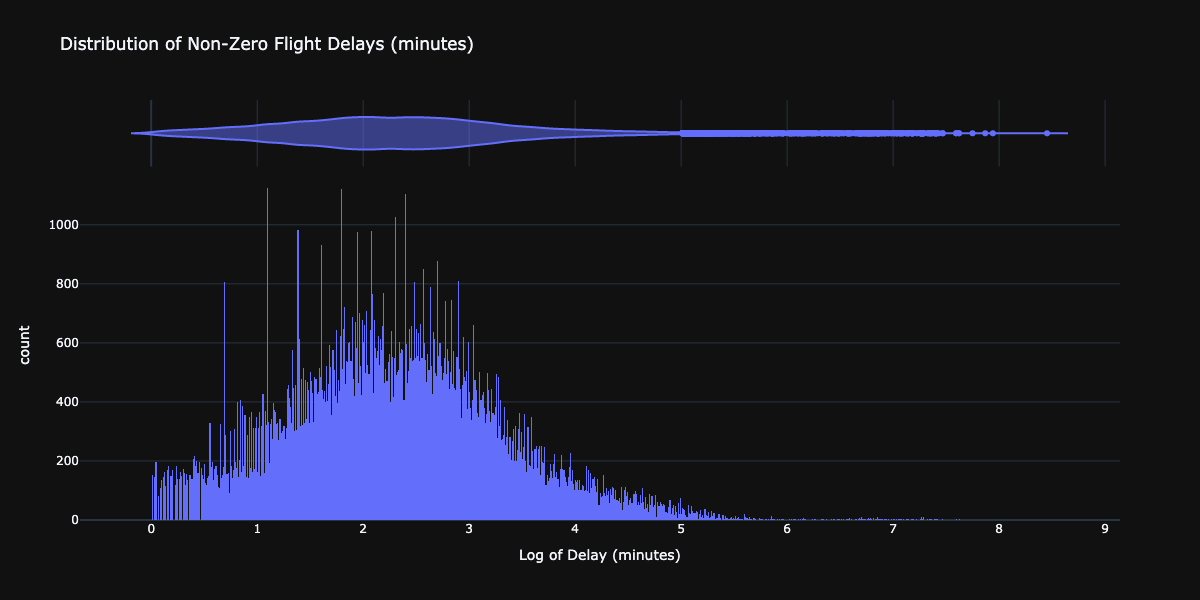

In [10]:
# Filter out rows with zero delays
non_zero_delays = df_flights[df_flights['delay_minutes_log'] > 0]

# Plot the histogram for non-zero delays
fig1 = px.histogram(
    non_zero_delays, 
    x='delay_minutes_log', 
    nbins=1500, 
    title="Distribution of Non-Zero Flight Delays (minutes)",
    labels={'delay_minutes_log': 'Log of Delay (minutes)'},
    marginal="violin",  # adds a violin plot to show distribution shape
)
fig1.update_layout(
    width=1200,
    height=600,  # set x-axis range to focus on delays < 300 minutes
)
fig1.show()

In [11]:
# Display pandas groupby view for count of flights that had 0 delay vs count that had non-zero-delay
delay_counts = df_flights['delay_minutes'].apply(lambda x: 'no_delay' if x == 0 else 'less_than_10_minutes_delay' if x <= 10 else 'more_than_10_minutes_delay').value_counts()
display(delay_counts)

# Calculate and display the class imbalance percentage
total_flights = delay_counts.sum()
no_delay_percentage = (delay_counts['no_delay'] / total_flights) * 100
zero_delay_percentage = (delay_counts['less_than_10_minutes_delay'] / total_flights) * 100
non_zero_delay_percentage = (delay_counts['more_than_10_minutes_delay'] / total_flights) * 100


print(f"Percentage of flights with no delay: {no_delay_percentage:.2f}%")
print(f"Percentage of flights with less_than_10_minutes delay: {zero_delay_percentage:.2f}%")
print(f"Percentage of flights with more_than_10_minutes delay: {non_zero_delay_percentage:.2f}%")


delay_minutes
less_than_10_minutes_delay    87107
more_than_10_minutes_delay    70235
no_delay                      36663
Name: count, dtype: int64

Percentage of flights with no delay: 18.90%
Percentage of flights with less_than_10_minutes delay: 44.90%
Percentage of flights with more_than_10_minutes delay: 36.20%


In [12]:
df_flights['num_destinations'] = df_flights['route.destinations'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
df_flights['first_destination'] = df_flights['route.destinations'].apply(lambda x: eval(x)[0] if isinstance(x, str) and len(eval(x)) > 0 else None)

df_merged = pd.merge(
    df_flights, 
    df_airports, 
    how='left',
    left_on='first_destination', 
    right_on='IATA',
    suffixes=('', '_airport')
).dropna(subset=['IATA'])

# Now extract top-level region from something like "Europe/Paris" -> "Europe"
df_merged['region'] = df_merged['Tz'].str.split("/").str.get(0)

In [13]:
pd.set_option('display.max_columns', None)
display(df_merged.head())

,actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,expectedTimeOnBelt,flightDirection,flightName,flightNumber,gate,id,mainFlight,prefixIATA,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions,scheduledDeparture,delay_minutes,delay_minutes_log,num_destinations,first_destination,Airport,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,region
0,2018-01-01 03:22:00+01:00,PHPXB,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,D,ZXP022,22.0,NaN,123414481790510775,ZXP022,NaN,ZXP,NaN,['DEP'],['AMS'],2018-01-01,03:30:00,NaN,NaN,NaN,NaN,2018-01-01 03:30:00+01:00,0.000000,0.000000,1,AMS,580.0,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.76389,-11.0,1,E,Europe/Amsterdam,airport,OurAirports,Europe
1,2018-01-01 05:58:22+01:00,PHHSJ,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV5641,5641.0,D59,123414479288269149,HV5641,HV,TRA,NaN,['DEP'],['SPC'],2018-01-01,06:00:00,J,1.0,NaN,NaN,2018-01-01 06:00:00+01:00,0.000000,0.000000,1,SPC,1053.0,La Palma Airport,Santa Cruz De La Palma,Spain,SPC,GCLA,28.626499,-17.75560,107.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
2,2018-01-01 06:00:00+01:00,PHHSG,73H,73H,100.0,NaN,NaN,NaN,NaN,NaN,NaN,D,KL2533,2533.0,D86,123414479666542945,HV6455,KL,KLM,NaN,['DEP'],['LPA'],2018-01-01,06:05:00,J,1.0,NaN,NaN,2018-01-01 06:05:00+01:00,0.000000,0.000000,1,LPA,1054.0,Gran Canaria Airport,Gran Canaria,Spain,LPA,GCLP,27.931900,-15.38660,78.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
3,2018-01-01 06:00:00+01:00,PHHSG,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV6455,6455.0,D86,123414479288365061,HV6455,HV,TRA,NaN,['DEP'],['LPA'],2018-01-01,06:05:00,J,1.0,NaN,NaN,2018-01-01 06:05:00+01:00,0.000000,0.000000,1,LPA,1054.0,Gran Canaria Airport,Gran Canaria,Spain,LPA,GCLP,27.931900,-15.38660,78.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
4,2018-01-01 06:26:34+01:00,PHHXB,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV5801,5801.0,E08,123414479288274329,HV5801,HV,TRA,NaN,['DEP'],['TLV'],2018-01-01,06:15:00,J,1.0,NaN,NaN,2018-01-01 06:15:00+01:00,11.566667,2.531048,1,TLV,1590.0,Ben Gurion International Airport,Tel-aviv,Israel,TLV,LLBG,32.011398,34.88670,135.0,2,E,Asia/Jerusalem,airport,OurAirports,Asia


In [14]:
# Ensure no negative delays
df_merged['delay_minutes'] = df_merged['delay_minutes'].clip(lower=0)

# Create a log transform column (log(delay + 1))
df_merged['log_delay'] = np.log1p(df_merged['delay_minutes'])

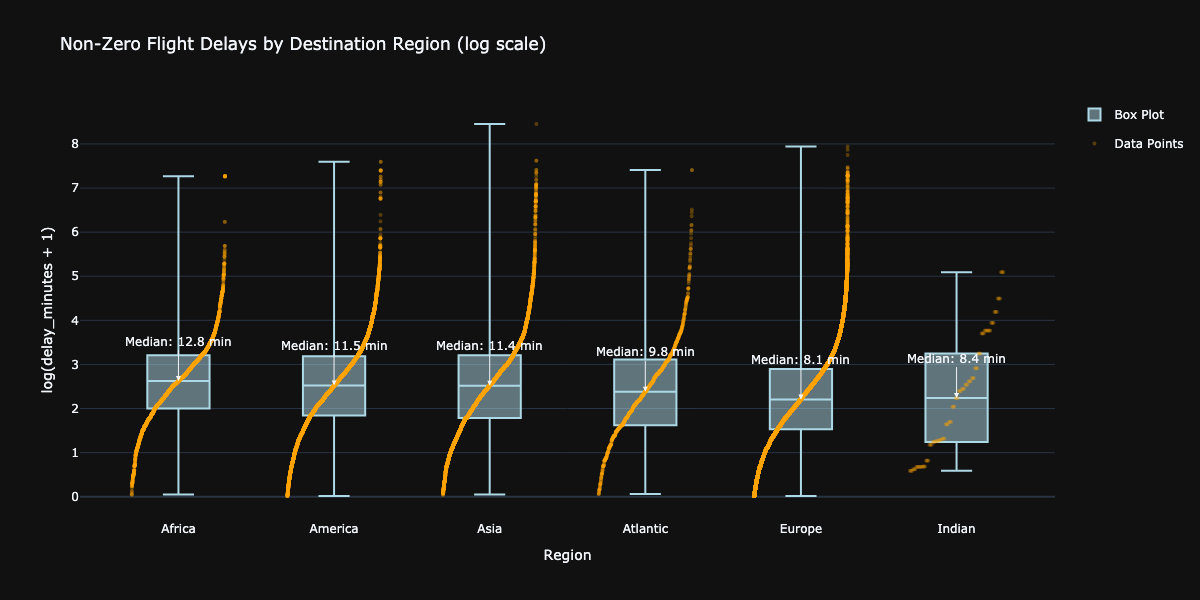

In [28]:
# Filter out \N region and sort remaining regions
regions_sorted = sorted([reg for reg in df_merged['region'].dropna().unique() if reg != '\\N'])
region_to_num = {reg: i for i, reg in enumerate(regions_sorted)}

fig = go.Figure()

for idx, reg in enumerate(regions_sorted):
    # Filter for the current region and non-zero delays
    subset = df_merged[(df_merged['region'] == reg) & (df_merged['log_delay'] > 0)]
    
    # Calculate median of actual delay (not log)
    median_delay = subset['delay_minutes'].median()
    
    # Add standard Box trace with increased width
    fig.add_trace(go.Box(
        x=[region_to_num[reg]] * len(subset),
        y=subset['log_delay'],
        name="Box Plot" if idx == 0 else None,
        legendgroup="BoxPlot",
        showlegend=(idx==0),
        boxpoints=False,
        marker_color='lightblue',
        line_color='lightblue',
        quartilemethod="linear",
        width=0.4
    ))
    
    # Sort the data points and compute evenly spaced jitter for x positions
    sorted_y = np.sort(subset['log_delay'])
    jitter = np.linspace(-0.3, 0.3, len(sorted_y))
    x_positions = region_to_num[reg] + jitter
    
    # Add Scatter trace for sorted data points overlay
    fig.add_trace(go.Scatter(
        x=x_positions,
        y=sorted_y,
        mode='markers',
        name="Data Points" if idx == 0 else None,
        legendgroup="Scatter",
        showlegend=(idx==0),
        marker=dict(color='orange', size=4, opacity=0.3)
    ))
    
    # Add annotation for median delay
    fig.add_annotation(
        x=region_to_num[reg],
        y=np.log1p(median_delay),  # Convert median delay to log scale for positioning
        text=f"Median: {median_delay:.1f} min",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )

# Update Layout
fig.update_layout(
    title="Non-Zero Flight Delays by Destination Region (log scale)",
    xaxis=dict(
        title="Region",
        tickmode='array',
        tickvals=list(region_to_num.values()),
        ticktext=list(region_to_num.keys())
    ),
    yaxis=dict(
        title="log(delay_minutes + 1)"
    ),
    boxmode='group',
    width=1200,
    height=600,
)

fig.show()

### Class understanding: How many clients have applied for credit and how often?

In [14]:
num_clients_applied = (
    df_merged.groupby("client_nr")["credit_application"]
    .sum()
    .gt(0) 
    .sum()
)

total_clients = df_merged["client_nr"].nunique()

print(f"Total number of clients: {total_clients}")
print(f"Clients who applied at least once: {num_clients_applied}")
print(f"Percentage of clients who applied at least once: {(100.0 * num_clients_applied / total_clients):.2f}%")

Total number of clients: 992
Clients who applied at least once: 607
Percentage of clients who applied at least once: 61.19%


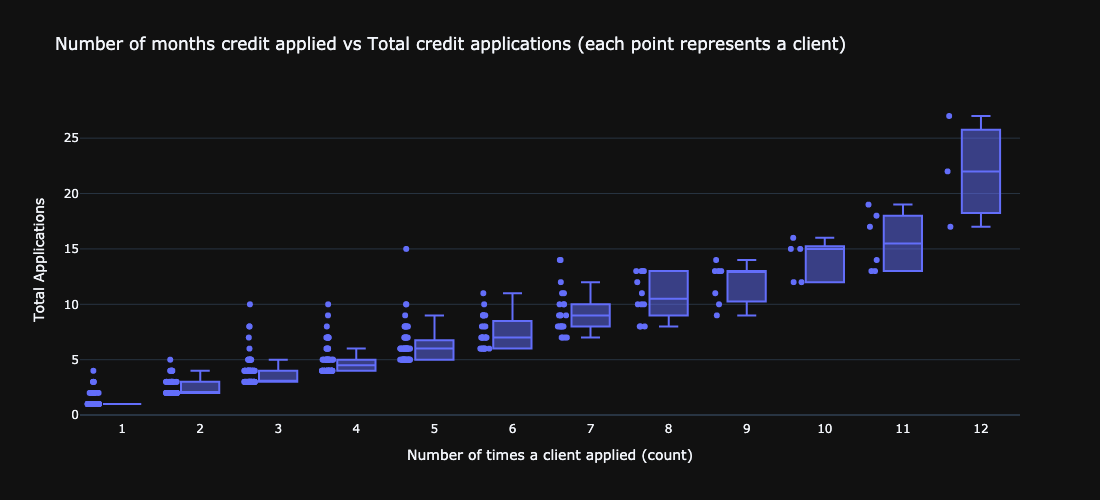

In [34]:
df_applied_months = df_merged[df_merged["credit_application"] == 1].copy()
df_applied_months["client_nr_str"] = df_applied_months["client_nr"].astype(str)

df_client_summary = (
    df_applied_months
    .groupby(["client_nr_str","CRG"], as_index=False)
    .agg(
        months_applied=("nr_credit_applications", "count"),
        total_nr_apps=("nr_credit_applications", "sum")
    )
)

fig = px.box(
    df_client_summary,
    x="months_applied",
    y="total_nr_apps",
    title="Number of months credit applied vs Total credit applications (each point represents a client)",
    points="all"
)
fig.update_layout(
    xaxis=dict(dtick=1),
    xaxis_title="Number of times a client applied (count)",
    yaxis_title="Total Applications",
    width=1100,
)
fig.show()

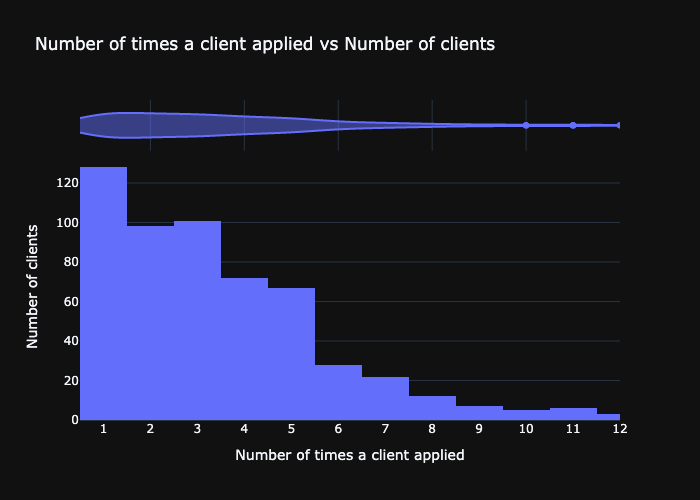

In [170]:
# Create a new column for the number of times a client applied
df_client_summary["num_times_applied"] = df_client_summary["months_applied"]

# Create a histogram plot
fig = px.histogram(
    df_client_summary,
    x="num_times_applied",
    nbins=20,
    marginal="violin",
    title="Number of times a client applied vs Number of clients",
    labels={"num_times_applied": "Number of times a client applied", "count": "Number of clients"},
    histnorm=None
)

fig.update_layout(
    xaxis=dict(dtick=1, range=[0.5, df_client_summary["num_times_applied"].max()]),
    xaxis_title="Number of times a client applied",
    yaxis_title="Number of clients",
    width=700,
)

fig.show()


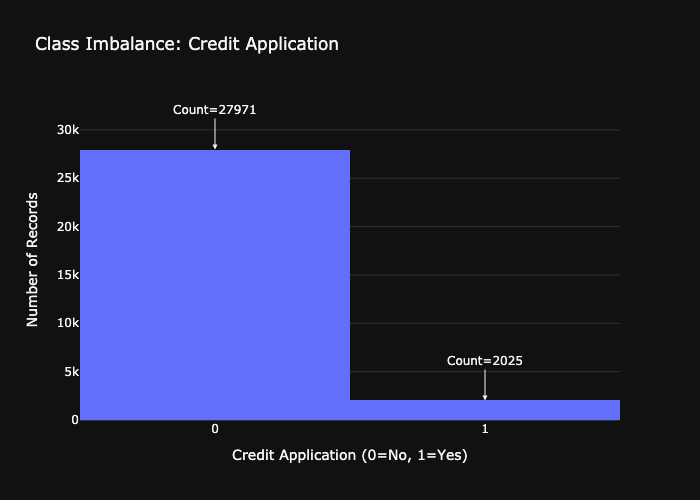

In [172]:
fig = px.histogram(
    df_merged,
    x="credit_application",
    title="Class Imbalance: Credit Application",
    labels={"credit_application": "Credit Application (0=No, 1=Yes)", "count": "Number of Records"},
    histnorm=None
)

class_counts = df_merged["credit_application"].value_counts().sort_index()
annotations = [
    dict(
        x=cls,
        y=count,
        text=f"Count={count}",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )
    for cls, count in class_counts.items()
]
fig.update_layout(
    xaxis=dict(dtick=1),
    xaxis_title="Credit Application (0=No, 1=Yes)",
    yaxis_title="Number of Records",
    width=700,
    annotations=annotations
)

fig.show()

### Feature understanding

### Total features

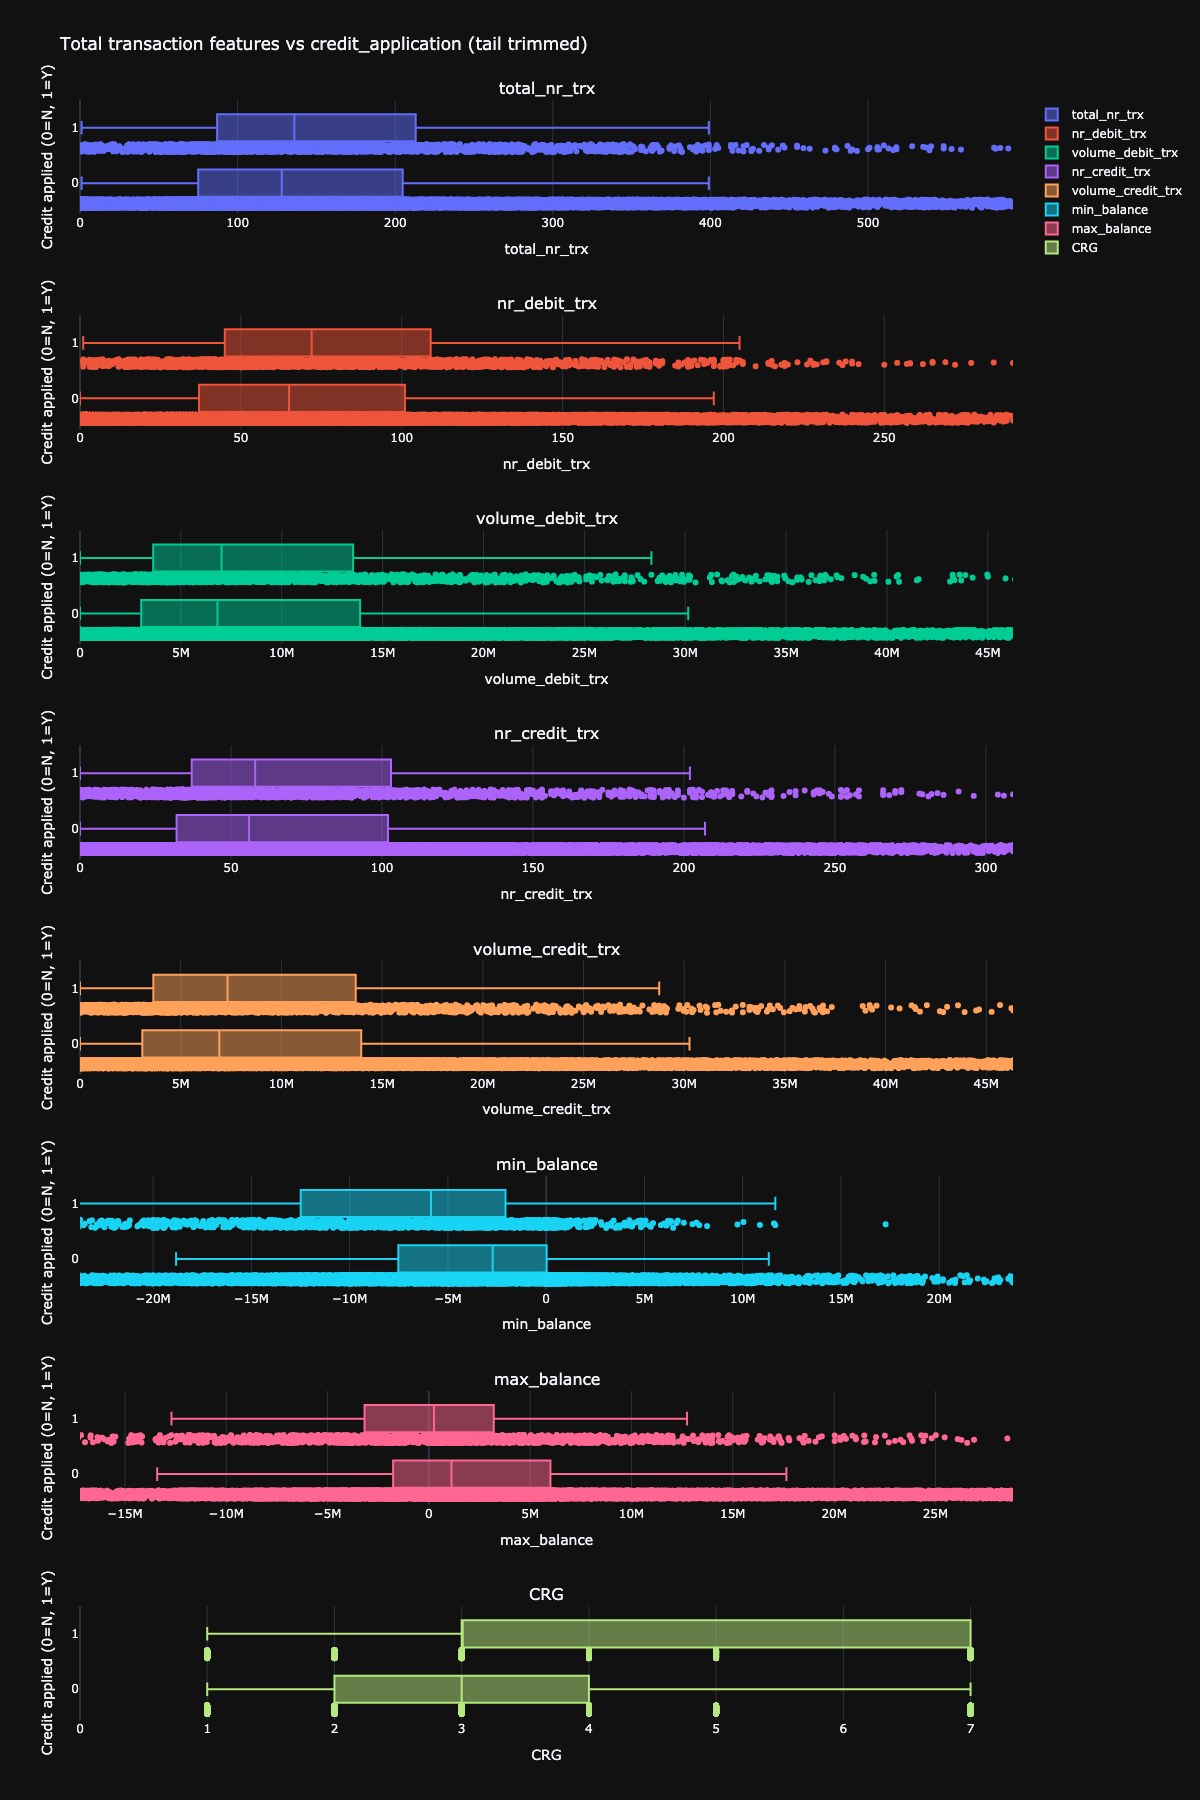

In [78]:
features = ["total_nr_trx", "nr_debit_trx", "volume_debit_trx", "nr_credit_trx", "volume_credit_trx", "min_balance", "max_balance", "CRG"]

fig = make_subplots(rows=8, cols=1, subplot_titles=features)

for i, feat in enumerate(features):
    q1 = df_merged[feat].quantile(0.25)
    q3 = df_merged[feat].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 3 * iqr if "CRG" not in feat else None
    lower_bound = q3 - 3 * iqr if "balance" in feat else 0

    trace = go.Box(
        x=df_merged[feat],
        y=df_merged["credit_application"],
        orientation="h",
        boxpoints="all",
        name=feat          
    )

    row = i + 1
    col = 1
    fig.add_trace(trace, row=row, col=col)
    fig.update_yaxes(
        title_text="Credit applied (0=N, 1=Y)",
        row=row, col=col
    )
    fig.update_xaxes(
        title_text=feat,
        range=[lower_bound, upper_bound],
        row=row, col=col
    )
    
fig.update_layout(
    title="Total transaction features vs credit_application (tail trimmed)",
    width=1200,
    height=1800
)
fig.show()

### Temporal dependencies: When do the clients apply for credit

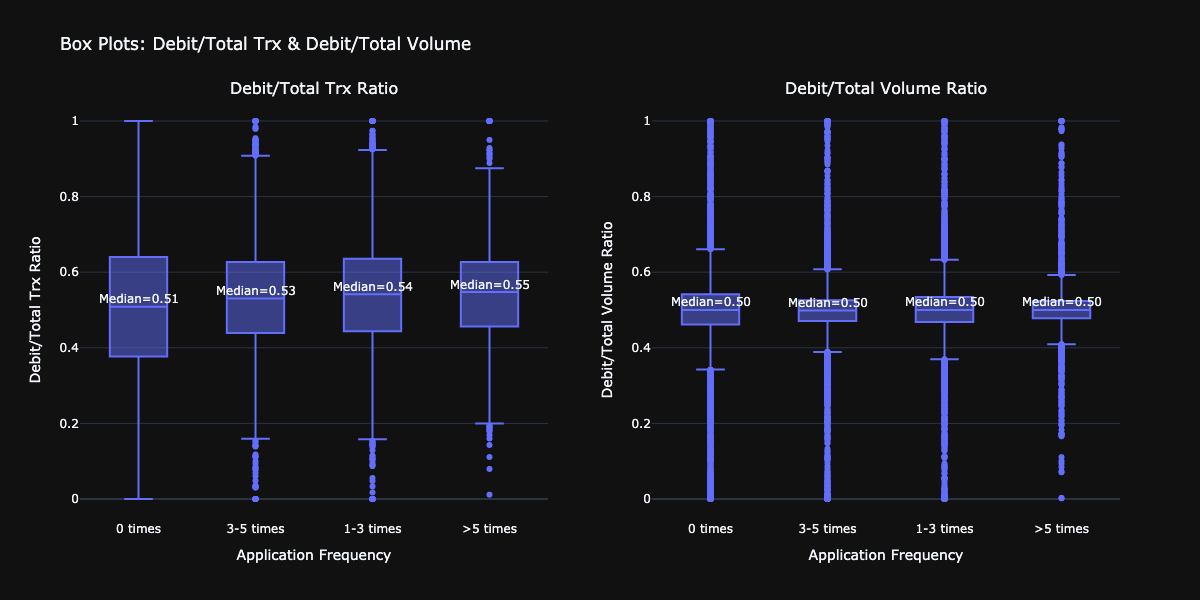

In [123]:
def create_boxplot_figure(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    xaxis_label: str,
    yaxis_label: str
) -> go.Figure:
    fig = px.box(
        df,
        x=x_col,
        y=y_col,
        title=title
    )
    group_medians = df.groupby(x_col)[y_col].median()
    for category, median_val in group_medians.items():
        fig.add_annotation(
            x=category,
            y=median_val,
            text=f"Median={median_val:.2f}",
            showarrow=False,
            yshift=8
        )
    fig.update_layout(
        xaxis_title=xaxis_label,
        yaxis_title=yaxis_label
    )

    return fig

df_merged_copy = df_merged.copy()
df_merged_copy["ratio_debit_total_trx"] = (
    df_merged_copy["nr_debit_trx"] / df_merged_copy["total_nr_trx"]
)

df_merged_copy["ratio_debit_total_volume"] = (
    df_merged_copy["volume_debit_trx"] /
    (df_merged_copy["volume_credit_trx"] + df_merged_copy["volume_debit_trx"])
)

df_merged_copy = df_merged_copy.sort_values(["client_nr", "yearmonth"]).reset_index(drop=True)

df_app_count = (
    df_merged_copy.groupby("client_nr")["credit_application"]
    .sum()
    .reset_index(name="total_applications")
)

def categorize_apps(x):
    if x == 0:
        return "0 times"
    elif 1 <= x < 3:
        return "1-3 times"
    elif 3 <= x <= 5:
        return "3-5 times"
    else:
        return ">5 times"

df_app_count["application_category"] = df_app_count["total_applications"].apply(categorize_apps)

df_labeled = pd.merge(
    df_merged_copy,
    df_app_count[["client_nr", "application_category"]],
    on="client_nr",
    how="left"
)

# (B) Create two separate box plot figures via the helper function
fig_left = create_boxplot_figure(
    df=df_labeled,
    x_col="application_category",
    y_col="ratio_debit_total_trx",
    title="(A) Debit/Total Transaction Count Ratio",
    xaxis_label="Application Frequency",
    yaxis_label="Debit/Total Trx Ratio"
)

fig_right = create_boxplot_figure(
    df=df_labeled,
    x_col="application_category",
    y_col="ratio_debit_total_volume",
    title="(B) Debit/Total Volume Ratio",
    xaxis_label="Application Frequency",
    yaxis_label="Debit/Total Volume Ratio"
)

# (C) Combine them side by side using make_subplots
fig_combined = make_subplots(rows=1, cols=2, subplot_titles=[
    "Debit/Total Trx Ratio", "Debit/Total Volume Ratio"
])

# Add the box plot traces from each figure
for trace in fig_left.data:
    fig_combined.add_trace(trace, row=1, col=1)
for trace in fig_right.data:
    fig_combined.add_trace(trace, row=1, col=2)


for ann in fig_left.layout.annotations:
    new_ann = ann.to_plotly_json()
    new_ann["xref"] = "x"   # subplot 1 x-axis
    new_ann["yref"] = "y"   # subplot 1 y-axis
    fig_combined.add_annotation(new_ann)

for ann in fig_right.layout.annotations:
    new_ann = ann.to_plotly_json()
    new_ann["xref"] = "x2"  # subplot 2 x-axis
    new_ann["yref"] = "y2"  # subplot 2 y-axis
    fig_combined.add_annotation(new_ann)

# Update axis labels for each subplot
fig_combined.update_xaxes(title_text="Application Frequency", row=1, col=1)
fig_combined.update_yaxes(title_text="Debit/Total Trx Ratio", row=1, col=1)

fig_combined.update_xaxes(title_text="Application Frequency", row=1, col=2)
fig_combined.update_yaxes(title_text="Debit/Total Volume Ratio", row=1, col=2)

fig_combined.update_layout(
    title="Debit/Total Trx & Debit/Total Volume",
    width=1200,
    height=600
)

fig_combined.show()

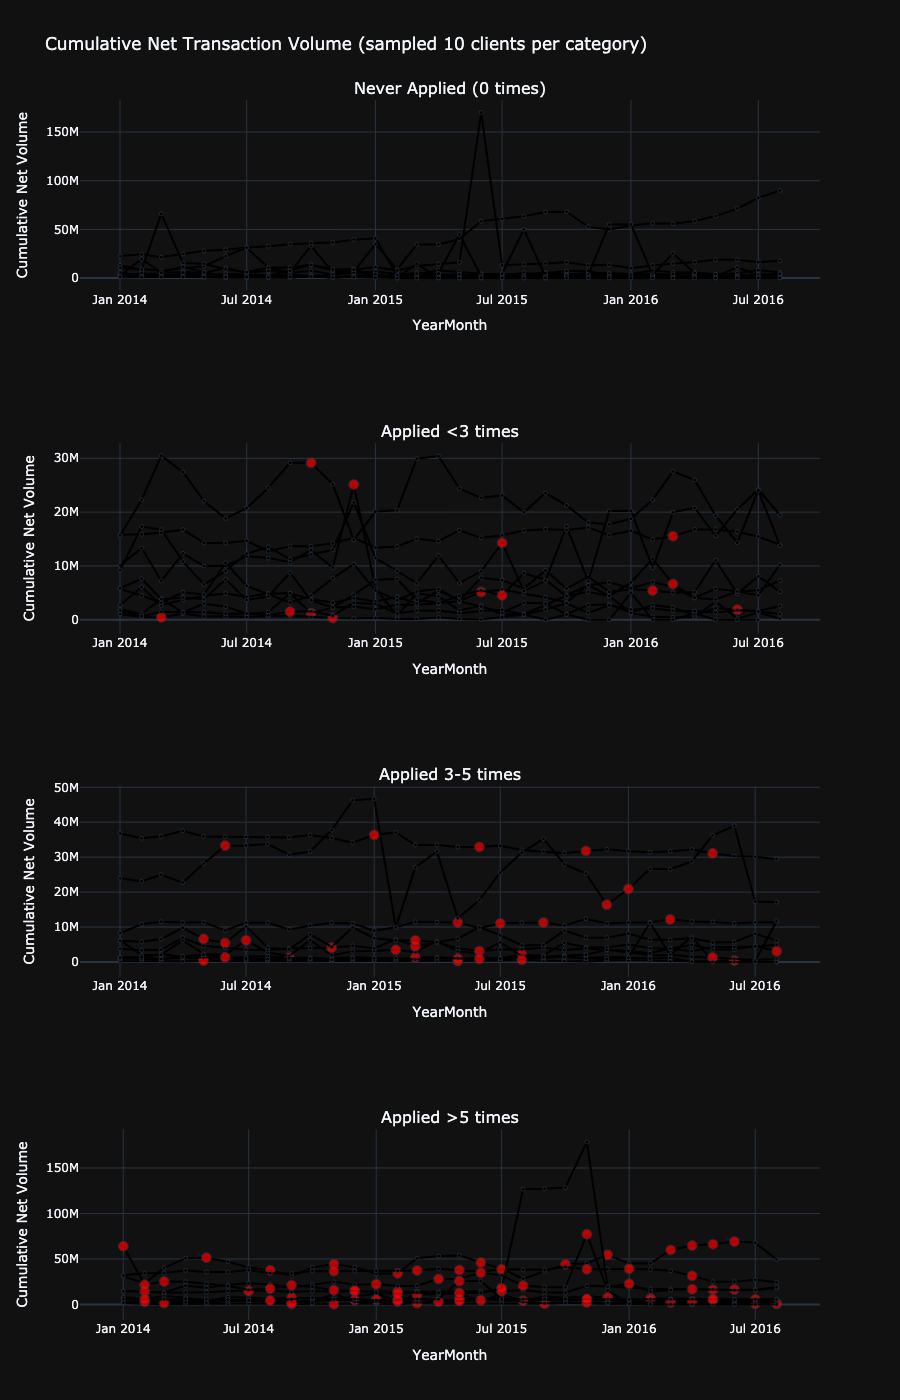

In [145]:
df = df_merged.copy()

# 1. Compute net transaction volume each month
df["net_trx_volume"] = df["volume_credit_trx"] - df["volume_debit_trx"]
df["range_balance"] = (df["max_balance"] - df["min_balance"])
df["net_trx_ratio"] = df["volume_credit_trx"] / (df["volume_debit_trx"]+df["volume_credit_trx"])


# 2. Sort by (client_nr, yearmonth) so cumsum is correct
df = df.sort_values(["client_nr", "yearmonth"]).reset_index(drop=True)

# 3. Summarize total applications per client
df_app_count = (
    df.groupby("client_nr")["credit_application"]
    .sum()
    .reset_index(name="total_applications")
)

# 4. Define the categories (conditions) and subplot labels
categories = {
    "Never Applied (0 times)": (df_app_count["total_applications"] == 0),
    "Applied <3 times":        (df_app_count["total_applications"] > 0) & (df_app_count["total_applications"] < 3),
    "Applied 3-5 times":        (df_app_count["total_applications"] >= 3) & (df_app_count["total_applications"] < 5),
    "Applied >5 times":       (df_app_count["total_applications"] > 5)
}

# 5. Create subplots: 3 rows, 1 column
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=False,
    subplot_titles=list(categories.keys())
)

# 6. Loop over each category to create each subplot row
for i, (cat_label, cat_mask) in enumerate(categories.items()):
    row = i + 1
    
    # Identify clients in this category
    clients_in_cat = df_app_count.loc[cat_mask, "client_nr"].unique()
    
    # Sample up to 50 clients if there are more than 50
    if len(clients_in_cat) > 50:
        clients_in_cat = np.random.choice(clients_in_cat, size=10, replace=False)
    
    # Filter main df to those sampled clients
    df_sub = df[df["client_nr"].isin(clients_in_cat)].copy()
    
    # Plot each client in this category
    for client_id in df_sub["client_nr"].unique():
        df_c = df_sub[df_sub["client_nr"] == client_id].copy()
        
        # Cumulative sum of net_trx_volume
        df_c["cum_net_trx"] = df_c["net_trx_volume"].cumsum()
        # df_c["cum_avg_balance"] = df_c["avg_balance"].cumsum()
        df_c["cum_net_trx_ratio"] = df_c["net_trx_ratio"].cumsum()
        
        # Markers: red if credit_application=1, black otherwise
        marker_colors = ["red" if x == 1 else "black" for x in df_c["credit_application"]]
        # Marker sizes: bigger if credit_application=1, smaller if 0
        marker_sizes = [10 if x == 1 else 4 for x in df_c["credit_application"]]
        
        # Scatter trace with lines+markers
        trace = go.Scatter(
            x=df_c["yearmonth"].astype(str),
            y=df_c["range_balance"],
            mode="lines+markers",
            marker=dict(
                color=marker_colors,
                size=marker_sizes
            ),
            line=dict(color="black"),
            name=f"Client {client_id}",
            showlegend=False
        )
        
        fig.add_trace(trace, row=row, col=1)

    # Update axis labels for this subplot
    fig.update_xaxes(title_text="YearMonth", row=row, col=1)
    fig.update_yaxes(title_text="Cumulative Net Volume", row=row, col=1)

fig.update_layout(
    title="Cumulative Net Transaction Volume (sampled 10 clients per category)",
    width=900,
    height=1400
)

fig.show()

### Feature engineering

1. lags
2. month-to-month change
3. rolling averages

In [148]:
def engineer_time_based_features(
    df: pd.DataFrame,
    lags: list = [1, 2],
    rolling_windows: list = [3, 6]
) -> pd.DataFrame:
    df = df.copy()

    # 1. Create combined columns
    # epsilon = 1e-9
    df["net_volume"] = df["volume_credit_trx"] - df["volume_debit_trx"]
    df["debit_total_trx_ratio"] = df["nr_debit_trx"] / (df["total_nr_trx"])
    df["debit_total_vol_ratio"] = df["volume_debit_trx"] / (
        df["volume_debit_trx"] + df["volume_credit_trx"]
    )
    df["balance_range"] = df["max_balance"] - df["min_balance"]

    # 2. Sort by (client_nr, yearmonth)
    df = df.sort_values(["client_nr", "yearmonth"]).reset_index(drop=True)

    # Define which columns we'll do shifting/rolling on
    time_series_cols = [
        "net_volume",
        "min_balance",
        "debit_total_trx_ratio",
        "debit_total_vol_ratio",
    ]

    # 3. Group by client_nr for time-based transformations
    def create_features_for_group(g: pd.DataFrame) -> pd.DataFrame:
        g["cumulative_applications"] = g["credit_application"].cumsum()
        g["cumulative_nr_applications"] = g["nr_credit_applications"].cumsum()
        # For each column of interest
        for col in time_series_cols:
            # a) LAGS: for each lag value in lags
            for lag_val in lags:
                g[f"{col}_lag{lag_val}"] = g[col].shift(lag_val)

            # b) ROLLING: for each window in rolling_windows
            #    We use a simple rolling mean with min_periods=1 (adjust if needed)
            for w in rolling_windows:
                g[f"{col}_rolling{w}"] = (
                    g[col].rolling(window=w, min_periods=1).mean()
                )

        return g

    # Apply this function to each client
    df = df.groupby("client_nr", group_keys=False).apply(create_features_for_group)

    return df

df_merged_with_features = engineer_time_based_features(df_merged)

In [149]:
df_merged_with_features.head()

,client_nr,yearmonth,credit_application,nr_credit_applications,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,...,min_balance_rolling3,min_balance_rolling6,debit_total_trx_ratio_lag1,debit_total_trx_ratio_lag2,debit_total_trx_ratio_rolling3,debit_total_trx_ratio_rolling6,debit_total_vol_ratio_lag1,debit_total_vol_ratio_lag2,debit_total_vol_ratio_rolling3,debit_total_vol_ratio_rolling6
0,1,2014-01-01,0,0,97,50,6527929,47,7454863,-7914288,...,-7.914288e+06,-7.914288e+06,NaN,NaN,0.515464,0.515464,NaN,NaN,0.466854,0.466854
1,1,2014-02-01,0,0,88,59,3475918,29,1895848,-8448513,...,-8.181400e+06,-8.181400e+06,0.515464,NaN,0.592959,0.592959,0.466854,NaN,0.556963,0.556963
2,1,2014-03-01,0,0,96,62,31316405,34,20083583,-10347650,...,-8.903484e+06,-8.903484e+06,0.670455,0.515464,0.610584,0.610584,0.647072,0.466854,0.574398,0.574398
3,1,2014-04-01,0,0,83,53,18669967,30,1091295,-15385039,...,-1.139373e+07,-1.052387e+07,0.645833,0.670455,0.651614,0.617577,0.609269,0.647072,0.733706,0.666993
4,1,2014-05-01,0,0,94,54,2893905,40,2034075,-15682170,...,-1.380495e+07,-1.155553e+07,0.638554,0.645833,0.619619,0.608955,0.944776,0.609269,0.713761,0.651042


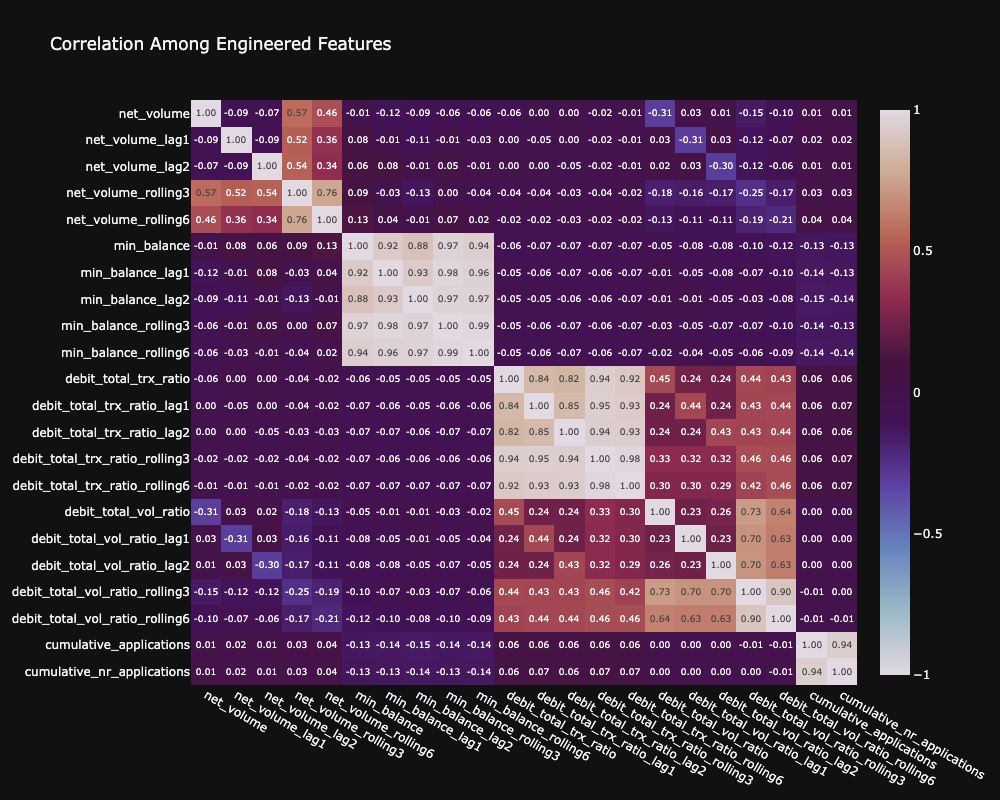

In [160]:
feature_cols = [
    "net_volume",
    "net_volume_lag1",
    "net_volume_lag2",
    "net_volume_rolling3",
    "net_volume_rolling6",
    "min_balance",
    "min_balance_lag1",
    "min_balance_lag2",
    "min_balance_rolling3",
    "min_balance_rolling6",
    "debit_total_trx_ratio",
    "debit_total_trx_ratio_lag1",
    "debit_total_trx_ratio_lag2",
    "debit_total_trx_ratio_rolling3",
    "debit_total_trx_ratio_rolling6",
    "debit_total_vol_ratio",
    "debit_total_vol_ratio_lag1",
    "debit_total_vol_ratio_lag2",
    "debit_total_vol_ratio_rolling3",
    "debit_total_vol_ratio_rolling6",
    "cumulative_applications",
    "cumulative_nr_applications",
]

# Filter out columns that might not exist if you didn’t create them:
feature_cols = [col for col in feature_cols if col in df_merged_with_features.columns]

# 2. Compute the correlation matrix (Pandas)
corr_matrix = df_merged_with_features[feature_cols].corr()

# 3. Create a Plotly heatmap with correlation values in each square
#    text_auto=True => show numeric values automatically
#    color_continuous_scale => choose e.g. "RdBu_r" for a red/blue diverging scale
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",  # format to 2 decimal places
    color_continuous_scale="twilight",
    range_color=[-1, 1],  # correlation range from -1 to 1
    aspect="auto",
    title="Correlation Among Engineered Features"
)

fig.update_layout(
    width=1000,
    height=800
)

fig.show()

In [164]:
# print the highest correlations feature pairs 15
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
top_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)].head(30)
print(top_corr_pairs)

min_balance_rolling3            min_balance_rolling6              0.985028
debit_total_trx_ratio_rolling6  debit_total_trx_ratio_rolling3    0.981793
min_balance_rolling3            min_balance_lag1                  0.979556
                                min_balance                       0.967341
min_balance_lag2                min_balance_rolling3              0.966440
                                min_balance_rolling6              0.965292
min_balance_rolling6            min_balance_lag1                  0.959749
debit_total_trx_ratio_lag1      debit_total_trx_ratio_rolling3    0.949166
cumulative_applications         cumulative_nr_applications        0.944272
debit_total_trx_ratio           debit_total_trx_ratio_rolling3    0.943867
min_balance                     min_balance_rolling6              0.942973
debit_total_trx_ratio_lag2      debit_total_trx_ratio_rolling3    0.942479
                                debit_total_trx_ratio_rolling6    0.934288
debit_total_trx_ratio_rol